# Supplemental Figure 3- simulations of V1 violation rates


This figure is a work in progress for simulations.

Here is the current status:

- wrote a class `SimulateV1FixationGrowth` that takes in a trial dataframe, animal id and can simulate growth and returns a simulated trail dataframe as well as a summary table that has metrics like the days to reach target for the simulation
  - it can take in warm up and post warm up violation rates to simulate, or samples from the animals true distribution to pick a warm up rate for the day
  - the true distributions are sampled from beta distributions given data from warm up and non-warm up trials for each animal to determine the alpha and beta.
  - number of trials is also sampled from a Normal distribution given data from each animal
    - these distributions were decided by plotting the raw data for all animals

Chat GPT convo for build: https://chatgpt.com/share/67e9728e-7728-8005-afb8-f1f9093fca23

Future goals:

- Figure A part 1

  - raw data of simulations & ground truth for a single animal for true, recovered and normative growth over days towards target. Will need to decide if simulations will be for multiple seeds, or single data points from a single seed.

- Figure A part 2
  - summary box swarm plots of days to train for the following conditions:
    - actual V1
    - normative (no violation rates)
    - no warm up violations + actual rate
    - no warm up violations 25, 30, 35% rate (standard practice)
  - will need to decide if want to include recovery or not
  - will need to decide how many seeds per animal, conditions (50-100?)

Engineering work to implement:

- currently can run a single animal, condition well will the class. Will need to expand this
  - multi seed per animal & summary
  - multi animal, multi seed
  - multi animal, multi seed, multi condition (maybe)?
- the first experiment to run will be a recovery analysis on all animals will multiple seeds to see how much error is incurred by the simulation. if it's a lot then just to actual and normative and forget the non-warm up things for now.


In [135]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils as u
import config as c

# Load Data


In [133]:
tdf = u.load_trials_df()
tdf = u.compute_days_relative_to_stage(tdf, stage=5) # note need to have first day in prove stage for days to target to turn on

Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


# Common Wrangle & EDA


In [128]:

DAYS_TO_TARGET_DF = (
    tdf.query("has_reached_target_fixation == True and fix_experiment == 'V1'")
    .groupby(["animal_id", "fix_experiment"], observed=True)[
        f"days_relative_to_stage_5"
    ]
    .min()
    .reset_index()
)

DAYS_TO_TARGET_DF.rename(
    columns={f"days_relative_to_stage_5": "days_to_target"},
    inplace=True,
)

DAYS_TO_TARGET_DF

,animal_id,fix_experiment,days_to_target
0,R040,V1,13
1,R042,V1,12
2,R046,V1,13
3,R048,V1,35
4,R050,V1,22
5,R052,V1,57
6,R054,V1,25
7,R056,V1,55


(0.0, 1.0)

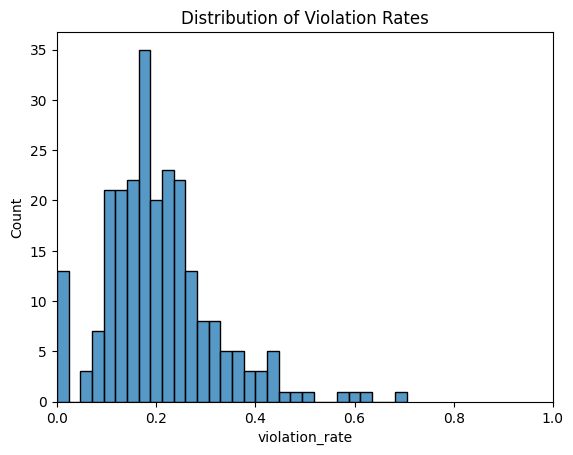

In [141]:
summary_animals = tdf.query("stage in @c.GROWING_STAGES and fix_experiment == 'V1'").groupby(["animal_id", "date", "days_relative_to_stage_5"]).agg(
    n_trials=("trial", "nunique"),
    violation_rate=("violations", "mean")
    ).reset_index()


fig, ax = plt.subplots()
sns.histplot(summary_animals, x="violation_rate", bins=30, ax=ax)
ax.set_title("Distribution of Violation Rates")
plt.xlim(0, 1)

Text(0.5, 1.0, 'Distribution of Number of Trials')

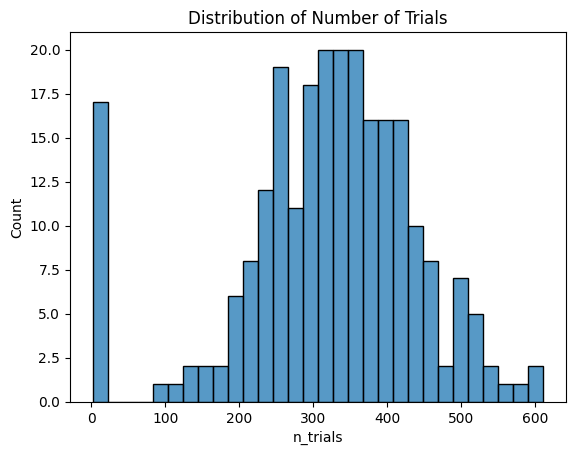

In [140]:
fig, ax = plt.subplots()
sns.histplot(summary_animals, x="n_trials", bins=30, ax=ax)
ax.set_title("Distribution of Number of Trials")

<Axes: xlabel='n_trials', ylabel='violation_rate'>

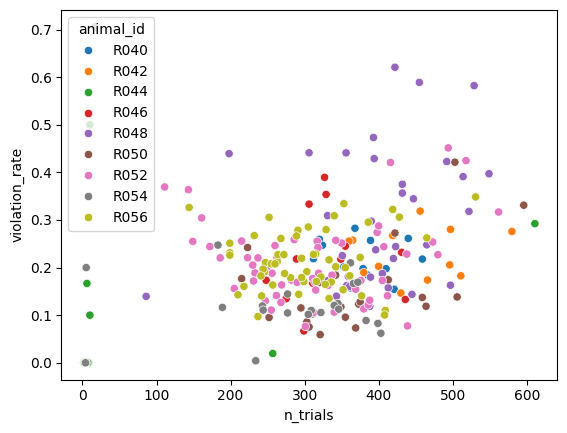

In [51]:
sns.scatterplot(data=summary_animals, x="n_trials", y="violation_rate", hue="animal_id")

# Dev with Class


In [142]:
import numpy as np
import pandas as pd

import config as c
import utils as u

from numpy.random import default_rng

class SimulateV1FixationGrowth:
    """
    A class to post-hoc simulate fixation growth data for a given animal,
    using empirical session-level statistics plus user-defined or default
    warm-up (wu_vr) and post-warm-up (pwu_vr) violation rates.
    """

    def __init__(
        self,
        tdf: pd.DataFrame,
        animal_id: str,
        wu_vr: float = None,
        pwu_vr: float = None,
        max_n_sessions: int = 90,
        experiment_name: str = "experiment",
        seed: int = None
    ):
        """
        Parameters
        ----------
        tdf : pd.DataFrame
            DataFrame of all trials for many animals. Must contain columns:
            [animal_id, stage, date, days_relative_to_stage_5, trial, violations].
            If 'days_relative_to_stage_5' is missing, it will be computed.
        animal_id : str
            The animal to filter on.
        wu_vr : float, optional
            Warm-up violation rate mean (if None, use empirical).
            If == 0, no violations are simulated in warm-up.
        pwu_vr : float, optional
            Post-warm-up violation rate mean (if None, use empirical).
            If == 0, no violations are simulated post warm-up.
        max_n_sessions : int, optional
            Maximum number of sessions to simulate before stopping.
        experiment_name : str, optional
            A label for the experiment (useful in summary).
        seed : int, optional
            If provided, used to initialize the RNG for reproducible simulations.
        """

        # If the required column is missing, compute days_relative_to_stage_5
        if "days_relative_to_stage_5" not in tdf.columns:
            tdf = u.compute_days_relative_to_stage(tdf.copy(), stage=5)

        self.tdf = tdf
        self.animal_id = animal_id
        self.max_n_sessions = max_n_sessions
        self.experiment_name = experiment_name

        # Renamed to reflect days to target in the simulation
        self.simulated_days_to_target = 0

        # Start with 0.01s (10 ms) as the "previous session’s final fixation"
        self.prev_session_dur = 0.010

        # Create a random number generator with an optional seed.
        self.rng = default_rng(seed)  # If seed is None, it uses a random seed.

        # Get the animal-level parameters (empirical means/vars, etc.)
        (
            self.emperical_wu_vr_mean,
            self.emperical_wu_vr_var,
            self.emperical_pwu_vr_mean,
            self.emperical_pwu_vr_var,
            self.emperical_n_trial_mean,
            self.emperical_n_trial_var,
            self.emperical_n_days_to_target
        ) = self.get_animal_parameters()

        # Decide on warm-up and post-warm-up violation rates
        # (If user didn’t specify, use empirical mean)
        self.wu_vr = self.emperical_wu_vr_mean if wu_vr is None else wu_vr
        self.pwu_vr = self.emperical_pwu_vr_mean if pwu_vr is None else pwu_vr

    def get_animal_parameters(self):
        """
        Filters `tdf` for this animal in the relevant GROWING_STAGES,
        then computes session-level stats for n_trials, violation_rate.

        Returns
        -------
        (wu_vr_mean, wu_vr_var, pwu_vr_mean, pwu_vr_var, n_trial_mean, n_trial_var, n_days_to_target)
        """

        # Filter the DataFrame for this animal and relevant stages
        animal_df = self.tdf.query(
            "animal_id == @self.animal_id and stage in @c.GROWING_STAGES"
        ).copy()

        # compute trial summary
        trial_summary = (
            animal_df.groupby(["animal_id", "date", "days_relative_to_stage_5"])
            .agg(
                n_trials=("trial", "nunique"),
            )
            .reset_index()
        )

        warm_up_summary = (
            animal_df.query("warm_up_imp == True")
            .groupby(["animal_id", "date", "days_relative_to_stage_5"])
            .agg(warm_up_violation_rate=("violations", "mean"))
            .reset_index()
        )

        non_warm_up_summary = (
            animal_df.query("warm_up_imp == False")
            .groupby(["animal_id", "date", "days_relative_to_stage_5"])
            .agg(non_warm_up_violation_rate=("violations", "mean"))
            .reset_index()
        )

        # merge the summaries
        session_summary = pd.merge(
            trial_summary, warm_up_summary,
            on=["animal_id", "date", "days_relative_to_stage_5"],
            how="left"
        )
        session_summary = pd.merge(
            session_summary, non_warm_up_summary,
            on=["animal_id", "date", "days_relative_to_stage_5"],
            how="left"
        )

        # Compute global means/vars
        pwu_vr_mean = session_summary["non_warm_up_violation_rate"].mean()
        pwu_vr_var = session_summary["non_warm_up_violation_rate"].var(ddof=1)
        if pd.isna(pwu_vr_var):
            pwu_vr_var = 0.0

        wu_vr_mean = session_summary["warm_up_violation_rate"].mean()
        wu_vr_var = session_summary["warm_up_violation_rate"].var(ddof=1)
        if pd.isna(wu_vr_var):
            wu_vr_var = 0.0

        n_trial_mean = session_summary["n_trials"].mean()
        n_trial_var = session_summary["n_trials"].var(ddof=1)
        if pd.isna(n_trial_var):
            n_trial_var = 0.0

        # For demonstration, define "n_days_to_target" as total number of sessions in growing stages
        n_days_to_target = len(session_summary)

        return (
            wu_vr_mean,
            wu_vr_var,
            pwu_vr_mean,
            pwu_vr_var,
            n_trial_mean,
            n_trial_var,
            n_days_to_target
        )

    def mean_var_to_alpha_beta(self, mean, var):
        """
        Given a mean and variance for a Beta distribution, compute alpha and beta.
        Clamps or returns (0,0) if mean == 0 (interpreted as no violations).
        """
        # If mean == 0 => no violation scenario
        if mean == 0:
            return 0.0, 0.0

        # Clamp mean just in case (particularly if user asked for >0.5, but they said they'd never do so)
        if mean >= 1.0:
            mean = 0.9999
        if mean <= 0.0:
            mean = 0.0001

        if var < 1e-6:
            var = 1e-6

        # Standard Beta parameterization
        alpha = (mean**2) * ((1.0 - mean) / var - 1.0 / mean)
        beta = alpha * (1.0 / mean - 1.0)

        # If we get negative alpha/beta, fallback to a small-variance distribution near mean
        if alpha <= 0 or beta <= 0:
            alpha = max(mean * 100, 1e-3)
            beta = max((1 - mean) * 100, 1e-3)

        return alpha, beta

    def sample_session_violation_rate(self, in_warm_up: bool) -> float:
        """
        Sample a session-level violation rate from a Beta distribution
        based on either warm-up (wu_vr) or post warm-up (pwu_vr).

        Returns a single float violation rate for the session.
        """
        if in_warm_up:
            mean_vr = self.wu_vr
            var_vr = self.emperical_wu_vr_var
        else:
            mean_vr = self.pwu_vr
            var_vr = self.emperical_pwu_vr_var

        if mean_vr == 0:
            # If mean is 0 => no violations at all
            return 0.0

        alpha, beta = self.mean_var_to_alpha_beta(mean_vr, var_vr)
        if (alpha == 0) and (beta == 0):
            # Interpreted as a "no violation" scenario
            return 0.0

        return self.rng.beta(alpha, beta)

    def sample_n_trials(self):
        """
        Samples the number of trials from a Normal distribution using the empirical
        mean and variance. Returns at least 1 trial.
        """
        sd = np.sqrt(self.emperical_n_trial_var)
        raw = self.rng.normal(self.emperical_n_trial_mean, sd)
        n_trials = int(round(raw))
        return max(n_trials, 1)

    def compute_warm_up_step(self) -> float:
        """
        Computes the warm-up step size.
        Warm-up step = (prev_session_dur - 0.01) / 20.
        """
        warm_up_target_duration = self.prev_session_dur
        starting_duration = 0.01
        n_warm_up_trials = 20

        return (warm_up_target_duration - starting_duration) / float(n_warm_up_trials)

    def simulate_session(self) -> pd.DataFrame:
        """
        Simulates a single session, returning a DataFrame with:
            [session, trial, fixation_dur, violation (bool), warm_up_on (bool)]

        Workflow:
          - Determine if warm-up is on/off (based on prev_session_dur > 0.01).
          - Sample session-level violation rate from Beta distribution.
          - For each trial:
              -> draw a Bernoulli violation from that session-level p
              -> if no violation, update fixation_dur accordingly.
        """

        n_trials = self.sample_n_trials()

        # Warm-up is ON if the previous session's final fixation was > 0.01
        warm_up_on = (self.prev_session_dur > 0.01)
        if warm_up_on:
            warm_up_step = self.compute_warm_up_step()

        # Sample a single session-level violation rate for warm-up or post-warm-up
        wuvr = self.sample_session_violation_rate(in_warm_up=True)
        pwuvr = self.sample_session_violation_rate(in_warm_up=False)

        # Start session at 0.01
        fixation_dur = 0.01

        trial_data = {
            "session": [],
            "trial": [],
            "fixation_dur": [],
            "violation": [],
            "warm_up_on": []
        }

        for t_idx in range(1, n_trials + 1):
            if warm_up_on and (t_idx <= 20):
                # Use the warm-up violation rate
                p_violate = wuvr
                did_violate = (self.rng.random() < p_violate)
                if not did_violate:
                    fixation_dur += warm_up_step
            else:
                # Post-warm-up
                p_violate = pwuvr
                did_violate = (self.rng.random() < p_violate)
                if not did_violate:
                    # Grow by 0.1% of current fixation or 0.001s, whichever is larger
                    grow_amount = max(0.001, 0.001 * fixation_dur)
                    fixation_dur += grow_amount

            trial_data["session"].append(self.simulated_days_to_target + 1)
            trial_data["trial"].append(t_idx)
            trial_data["fixation_dur"].append(fixation_dur)
            trial_data["violation"].append(did_violate)
            trial_data["warm_up_on"].append(warm_up_on and (t_idx <= 20))

        # End of session: increment day count, store final fixation for next session
        self.simulated_days_to_target += 1
        self.prev_session_dur = fixation_dur

        return pd.DataFrame(trial_data)

    def run_simulation(self):
        """
        Runs up to `max_n_sessions` sessions or until fixation_dur >= 2.0s.
        Returns:
          - A DataFrame of all trial-level data.
          - A single-row summary (dict) with:
             {
                 'animal_id': ...,
                 'wu_vr': ...,
                 'pwu_vr': ...,
                 'emperical_pwu_vr_var': ...,
                 'emperical_pwu_vr_mean': ...,
                 'emperical_wu_vr_var': ...,
                 'emperical_wu_vr_mean': ...,
                 'simulated_days_to_target': ...,
                 'experiment_name': ...,
                 'emperical_days_to_target': ...
             }
        """

        all_sessions = []
        for _ in range(self.max_n_sessions):
            session_df = self.simulate_session()
            all_sessions.append(session_df)

            # Stop if we reached or exceeded 2.0s fixation
            if self.prev_session_dur >= 2.0:
                break

        sim_data = pd.concat(all_sessions, ignore_index=True)

        summary = {
            "animal_id": self.animal_id,
            "wu_vr": self.wu_vr,
            "pwu_vr": self.pwu_vr,
            "emperical_pwu_vr_var": self.emperical_pwu_vr_var,
            "emperical_pwu_vr_mean": self.emperical_pwu_vr_mean,
            "emperical_wu_vr_var": self.emperical_wu_vr_var,
            "emperical_wu_vr_mean": self.emperical_wu_vr_mean,
            "emperical_days_to_target": self.emperical_n_days_to_target,
            "simulated_days_to_target": self.simulated_days_to_target,
            "experiment_name": self.experiment_name,
        }

        return sim_data, summary

In [145]:
EXAMPLE_ANIMAL = 'R050'
r= SimulateV1FixationGrowth(tdf, animal_id=EXAMPLE_ANIMAL, experiment_name="Test Recovery", seed=30)
trials, summary = r.run_simulation()
summary

{'animal_id': 'R050',
 'wu_vr': 0.21904761904761902,
 'pwu_vr': 0.1516900354860735,
 'emperical_pwu_vr_var': 0.008813372942953231,
 'emperical_pwu_vr_mean': 0.1516900354860735,
 'emperical_wu_vr_var': 0.007369047619047618,
 'emperical_wu_vr_mean': 0.21904761904761902,
 'emperical_days_to_target': 22,
 'simulated_days_to_target': 20,
 'experiment_name': 'Test Recovery'}

In [146]:
r= SimulateV1FixationGrowth(tdf, animal_id=EXAMPLE_ANIMAL, experiment_name="Test Normative", wu_vr=0, pwu_vr=0, seed=30)
trials, summary = r.run_simulation()
summary

{'animal_id': 'R050',
 'wu_vr': 0,
 'pwu_vr': 0,
 'emperical_pwu_vr_var': 0.008813372942953231,
 'emperical_pwu_vr_mean': 0.1516900354860735,
 'emperical_wu_vr_var': 0.007369047619047618,
 'emperical_wu_vr_mean': 0.21904761904761902,
 'emperical_days_to_target': 22,
 'simulated_days_to_target': 6,
 'experiment_name': 'Test Normative'}

In [150]:
r= SimulateV1FixationGrowth(tdf, animal_id=EXAMPLE_ANIMAL, experiment_name="Test No Warm Up Violations", wu_vr=0, pwu_vr=0, seed=30)
trials, summary = r.run_simulation()
summary

{'animal_id': 'R050',
 'wu_vr': 0,
 'pwu_vr': 0,
 'emperical_pwu_vr_var': 0.008813372942953231,
 'emperical_pwu_vr_mean': 0.1516900354860735,
 'emperical_wu_vr_var': 0.007369047619047618,
 'emperical_wu_vr_mean': 0.21904761904761902,
 'emperical_days_to_target': 22,
 'simulated_days_to_target': 6,
 'experiment_name': 'Test No Warm Up Violations'}

# Figure 3Y- Days to Complete Stage 5


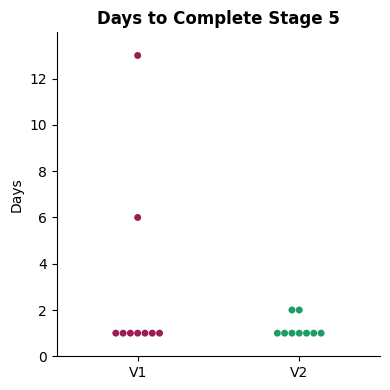

In [134]:
plot_df = (
    tdf.query("stage==5").groupby(["animal_id", "stage", "fix_experiment"], observed=True)
    .agg(n_days=pd.NamedAgg(column="date", aggfunc="nunique"))
    .reset_index()
)
plot_df
fig, ax = plt.subplots(figsize=(4,4))

sns.swarmplot(
    data=plot_df,
    x="fix_experiment",
    y="n_days",
    ax=ax,
    palette=c.EXP_PALETTE,
    hue="fix_experiment",
    order=c.HUE_ORDER_EXP,
)
sns.despine()

_ = ax.set_yticks(range(0, 14, 2))
_ = ax.set(ylabel="Days", xlabel="", ylim=(0, 14))

ax.set_title("Days to Complete Stage 5", fontweight="bold")

plt.tight_layout()
plt.savefig("figures/V0_figs3b_days_to_complete_stage_5.png", dpi=300, bbox_inches="tight")


# Dev with Single Animal


In [ ]:
EXAMPLE_ANIMAL = 'R050'
df = tdf.query("animal_id == @EXAMPLE_ANIMAL and stage in @c.GROWING_STAGES").copy()

summary_a = summary_animals.query("animal_id == @EXAMPLE_ANIMAL")


In [53]:
summary_a

,animal_id,date,days_relative_to_stage_5,n_trials,violation_rate
87,R050,2024-08-06,0,503,0.421471
88,R050,2024-08-07,1,422,0.272512
89,R050,2024-08-08,2,596,0.331092
90,R050,2024-08-09,3,464,0.11879
91,R050,2024-08-10,4,459,0.137255
92,R050,2024-08-11,5,506,0.13834
93,R050,2024-08-12,6,373,0.123324
94,R050,2024-08-13,7,413,0.174334
95,R050,2024-08-14,8,215,0.176744
96,R050,2024-08-15,9,223,0.242152


In [54]:
import pandas as pd
import numpy as np

def simulate_sessions_with_empirical_tail(df, num_days_to_sim, k=5):
    """
    Uses empirical data for days within the dataset.
    For days beyond the max day in the dataset, randomly samples
    from the last k days with replacement.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Must contain columns ["days_relative_to_stage_5", "n_trials", "violation_rate"].
        Each row is a session summary for that day.
    num_days_to_sim : int
        How many total days you want to simulate (including day 0).
    k : int
        How many days to pull from the tail when day > max_day.
        
    Returns:
    --------
    pd.DataFrame
        A DataFrame with columns ["sim_day", "n_trials", "violation_rate"] 
        representing the simulated sessions.
    """
    
    # 1. Identify the max real day in df
    max_day = df["days_relative_to_stage_5"].max()
    
    # 2. Create a lookup dict for quick access to (n_trials, violation_rate) by day
    #    This assumes exactly one row per day. If you have multiple rows per day,
    #    you might need to store them all and random-sample among them.
    day_to_data = {}
    for day, row in df.groupby("days_relative_to_stage_5"):
        # If multiple rows for one day, choose your own logic: 
        # e.g., average or random pick. Here we'll assume exactly one row per day.
        day_to_data[day] = (row["n_trials"].iloc[0], row["violation_rate"].iloc[0])
    
    # 3. Identify the last k days (the "tail" window)
    tail_start = max_day - (k - 1)  # e.g., if max_day=20 and k=5, tail range is 16..20
    tail_df = df.loc[df["days_relative_to_stage_5"].between(tail_start, max_day)]
    tail_pairs = tail_df[["n_trials", "violation_rate"]].values  # for random picking
    
    # 4. Build up a results list of dicts
    results = []
    for d in range(num_days_to_sim):
        if d <= max_day and d in day_to_data:
            # Use real data
            t_count, v_rate = day_to_data[d]
        else:
            # Beyond the last empirical day, or day not in data
            # Randomly sample from the tail
            t_count, v_rate = tail_pairs[np.random.choice(len(tail_pairs))]
        
        results.append({"sim_day": d, "n_trials": t_count, "violation_rate": v_rate})
    
    return pd.DataFrame(results)

In [55]:
df_sim = simulate_sessions_with_empirical_tail(summary_a, num_days_to_sim=30, k=5)
df_sim

,sim_day,n_trials,violation_rate
0,0,503,0.421471
1,1,422,0.272512
2,2,596,0.331092
3,3,464,0.118790
4,4,459,0.137255
5,5,506,0.138340
6,6,373,0.123324
7,7,413,0.174334
8,8,215,0.176744
9,9,223,0.242152


Left this in a fun spot- let's keep going (no polshing) and work on the specific simulation code. For now, assume warm up viol and viol have the same rate.
